# Introduction
Data from the Playground Series S3E20 competition
Predicting the CO2 emissions in Africa using satellite observations

Tools: pandas, matplotlib, scikit-learn and random forest.


# Libraries 
***

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import branca.colormap as cm
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestRegressor

from haversine import haversine

rs = 42

# Load data 
***

In [2]:
train = pd.read_csv('/Users/jacobc/Desktop/InputRwanda/train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test = pd.read_csv('/Users/jacobc/Desktop/InputRwanda/test.csv', index_col='ID_LAT_LON_YEAR_WEEK')

# Data analysis 
***

## Train data analysis

In [3]:
train.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 no

In [5]:
{col.split('_')[0] for col in train.columns}

{'CarbonMonoxide',
 'Cloud',
 'Formaldehyde',
 'NitrogenDioxide',
 'Ozone',
 'SulphurDioxide',
 'UvAerosolIndex',
 'UvAerosolLayerHeight',
 'emission',
 'latitude',
 'longitude',
 'week',
 'year'}

In [6]:
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending=False).head(20)

UvAerosolLayerHeight_aerosol_pressure                      78584
UvAerosolLayerHeight_solar_zenith_angle                    78584
UvAerosolLayerHeight_aerosol_height                        78584
UvAerosolLayerHeight_aerosol_optical_depth                 78584
UvAerosolLayerHeight_sensor_zenith_angle                   78584
UvAerosolLayerHeight_sensor_azimuth_angle                  78584
UvAerosolLayerHeight_solar_azimuth_angle                   78584
NitrogenDioxide_NO2_slant_column_number_density            18320
NitrogenDioxide_tropopause_pressure                        18320
NitrogenDioxide_tropospheric_NO2_column_number_density     18320
NitrogenDioxide_absorbing_aerosol_index                    18320
NitrogenDioxide_cloud_fraction                             18320
NitrogenDioxide_sensor_altitude                            18320
NitrogenDioxide_sensor_azimuth_angle                       18320
NitrogenDioxide_sensor_zenith_angle                        18320
NitrogenDioxide_solar_azi

In [7]:
# Number of missing values for each year
train.isnull().groupby(train['year']).sum().sum(axis=1)

year
2019    309254
2020    333338
2021    347499
dtype: int64

In [8]:
train[['year', 'emission']].describe()

,year,emission
count,79023.000000,79023.000000
mean,2020.000000,81.940552
std,0.816502,144.299648
min,2019.000000,0.000000
25%,2019.000000,9.797995
50%,2020.000000,45.593445
75%,2021.000000,109.549595
max,2021.000000,3167.768000


In [9]:
# Dataframes for visualization
train_plot = train.copy(deep=True)
train_plot['date'] = pd.to_datetime(train_plot['year'].astype(str) + '-' + train_plot['week_no'].astype(str) + '-1', format='%Y-%W-%w') # 1 is a monday and %w day of week otherwise throws error

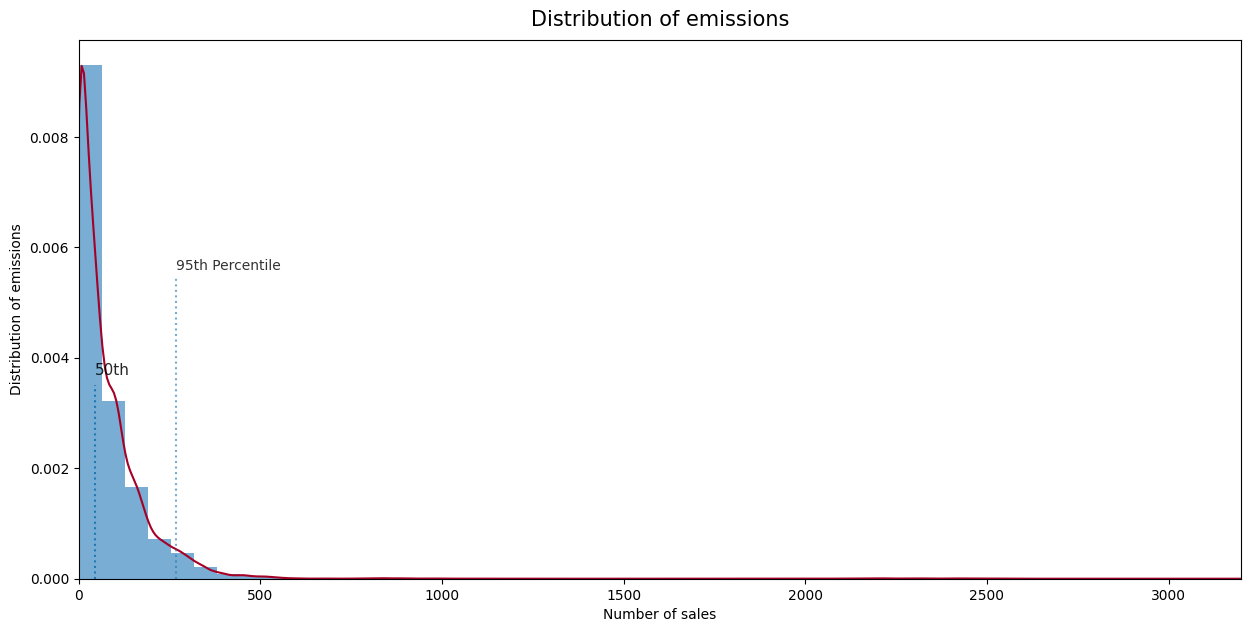

In [10]:
# Plot
train['emission'].plot(kind = "hist", density = True, alpha = 0.65, bins = 50, colormap='tab20c', figsize=(15,10)) # change density to true, because KDE uses density
train['emission'].plot(kind = "kde", colormap='RdYlBu', figsize=(15,7))

# Quantile lines
quant_50, quant_95 = train['emission'].quantile(0.5), train['emission'].quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_95, 0.6, 0.56]]
for i in quants:
    plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# X
plt.xlabel('Number of sales')
plt.xlim((0, 3200))

# Y
plt.ylabel('Distribution of emissions')

# # Annotations
plt.text(quant_50, .0037, "50th", size=11, alpha=.85)
plt.text(quant_95, .0056, "95th Percentile", size=10, alpha=.8)

plt.title('Distribution of emissions', size=15, pad=10)
plt.show()

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b> Most of emission readings aren't higher than 200.
</div>

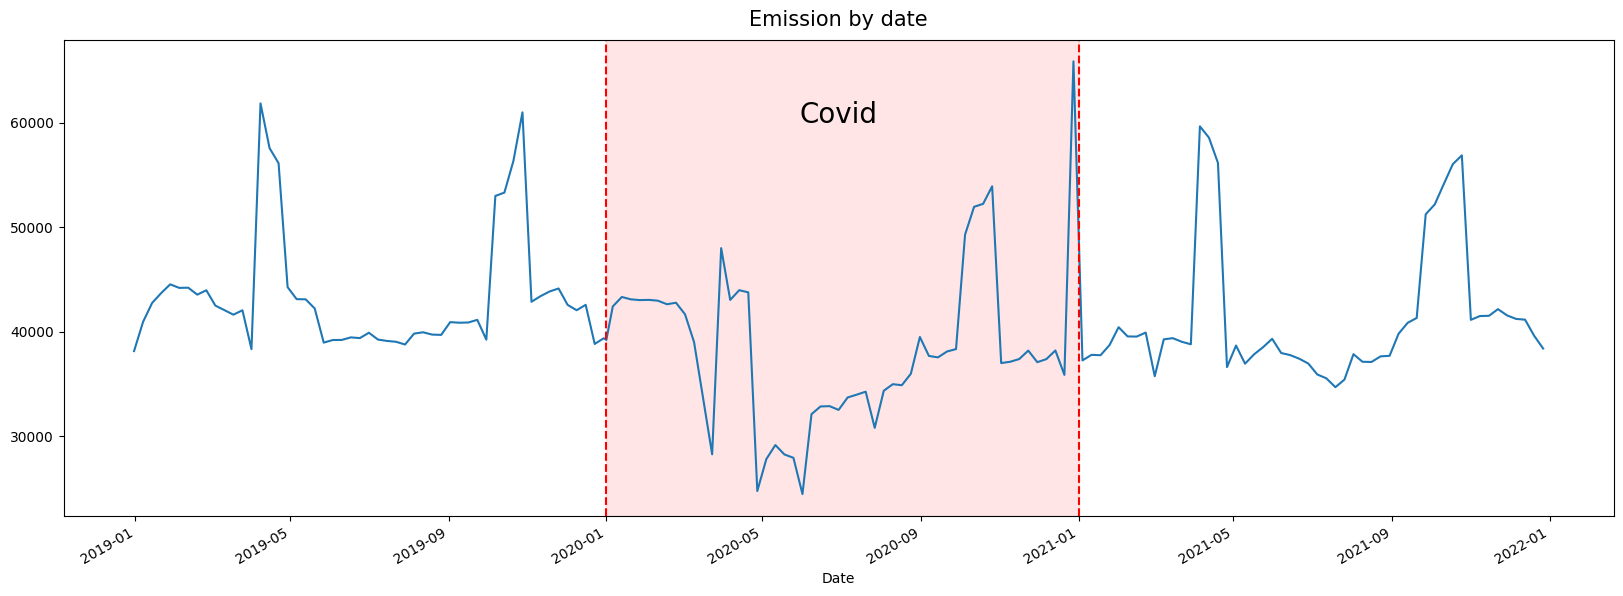

In [11]:
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='red', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='red')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='red')

plt.text(pd.Timestamp ('2020-05-30'), 60000, "Covid", size = 20)

plt.title('Emission by date', size=15, pad=10)
plt.show()

In [12]:
# Since 2020 is wierd I will remove it for this plot
mask = train_plot['date'].dt.year != 2020
train_plot_no_2020 = train_plot[mask]

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> </b> 
</div>

In [13]:
train.drop_duplicates(subset=['latitude', 'longitude']).shape[0]

497

In [14]:
zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
zero_emissions

,,emission
latitude,longitude,
-2.898,29.002,0.0
-2.859,29.041,0.0
-2.841,29.159,0.0
-2.817,29.283,0.0
-2.496,28.504,0.0
-1.974,28.526,0.0
-1.839,28.761,0.0
-1.833,28.467,0.0
-1.730,28.470,0.0


<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>Locations without emissions :</b>  15 locations where emmisions are always 0. 
</div>

In [15]:
grouped = train.groupby(['latitude', 'longitude'])['emission'].sum().reset_index()

colormap = cm.LinearColormap(['green', 'red'], vmin=0, vmax=75000) 

m = folium.Map(location=[grouped['latitude'].mean(), grouped['longitude'].mean()])

for _, row in grouped.iterrows():
    rows_emission = row['emission']
    color = 'blue' if rows_emission == 0 else colormap(rows_emission) if rows_emission < 10**5 else 'black'
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=np.sqrt(row['emission'])*15,
        color=color,
        fill=True,
        fill_color= color
    ).add_to(m)

m.fit_bounds(m.get_bounds())

m

<Axes: title={'center': 'Total emissions by location'}>

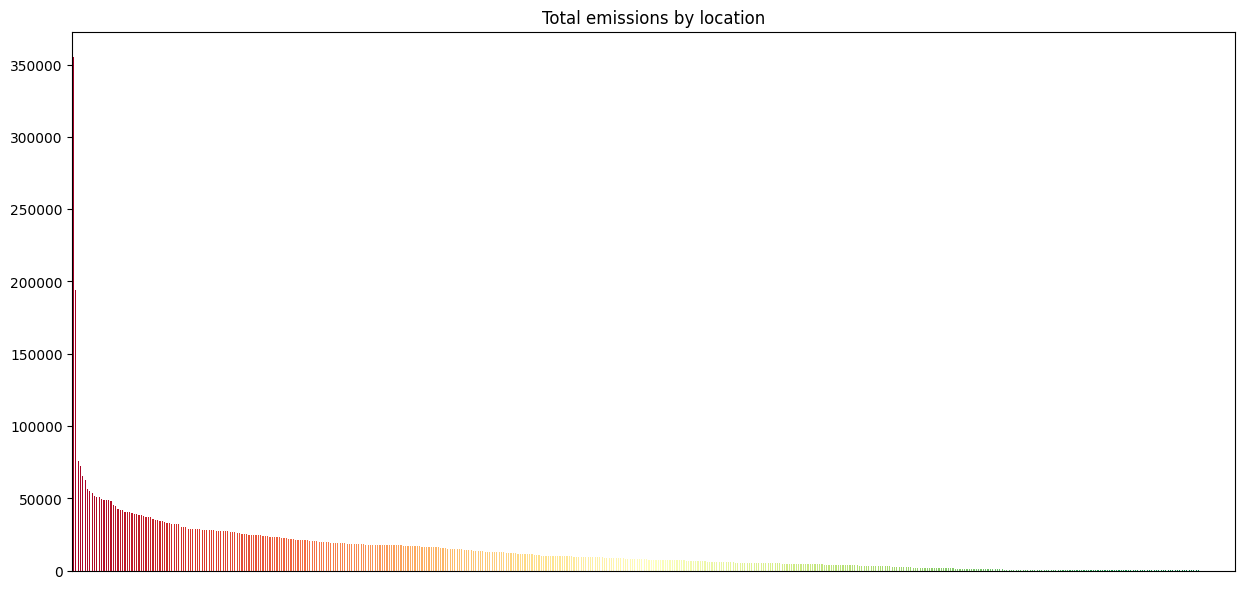

In [16]:
grouped['emission'].sort_values(ascending = False).plot(kind = 'bar', title = 'Total emissions by location', xticks = [], figsize=(15, 7), color=sns.color_palette('RdYlGn', n_colors=497))

In [17]:
np.array_equal(test[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values, train[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values)

True

# Feature engineering 
***

## Add date

In [18]:
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + train['week_no'].astype(str) + '-1', format='%Y-%W-%w') # '-1' means Monday, without it to_datetime() raises error 

## Drop Uv Aerosole feature group

In [19]:
train.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

## Fix virus year

In [20]:
# Calculate the average monthly sales for non-virus years (2019 and 2021)
avg_emission_non_virus = train[train['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()

# Calculate the average monthly for virus year (2020)
avg_emission_virus = train[train['year'] == 2020].groupby('week_no')['emission'].mean()

# Calculate the ratios for each month
ratios_for_weeks = avg_emission_non_virus/avg_emission_virus

# Multiply the num_sold column for each row in 2020 by the corresponding ratio for the week of that row
train.loc[train['year'] == 2020, 'emission'] *= train['week_no'].map(ratios_for_weeks)

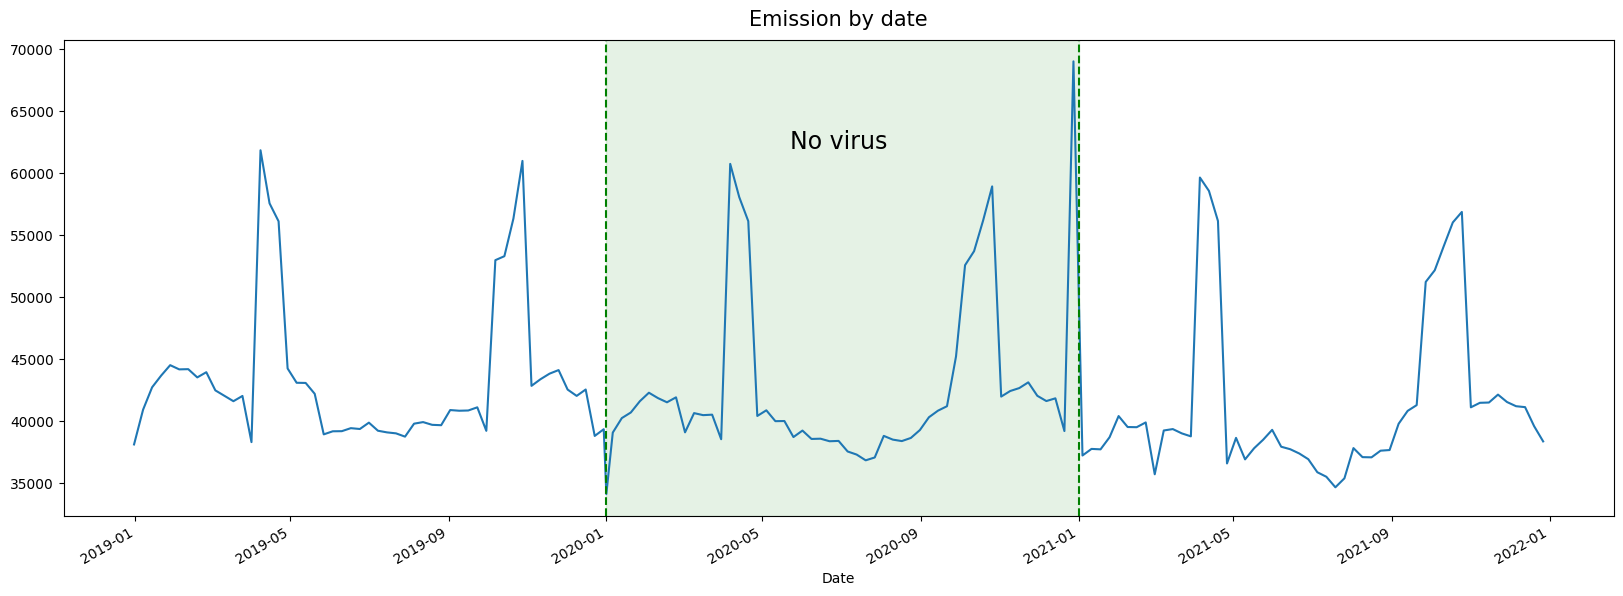

In [21]:
train.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp('2020-05-22'), 62000, "No COVID", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()

In [22]:
train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'] = np.power(train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'], 1/1.5)

## Season
Overall Rwanda's four climactic seasons are represented through the **long rainy season**: March to May, and **short rainy season**: September to November. These seasons alternate with the **long dry season**: June to August, and **short dry season**: December to February. Using that knowledge we will add `season` feature with **seasons labeled from 1 to 4**.

In [23]:
train['season'] = train['date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> 🏆 LB score:</b> Using <i>season</i> as a feature has negligible impact on the LB score by lowering it by 0.006 but it introduces more overfitting to a model so I won't use it for training.
</div>

## Holidays

In [24]:
train['holidays'] = (train['week_no'].isin([0, 51, 12, 30]))

## Cyclic features

In [25]:
train['week_sin'] = np.sin(2 * np.pi * train['week_no']/53)
train['week_cos'] = np.cos(2 * np.pi * train['week_no']/53)


## Rotating location

In [26]:
# From Yang Zhou https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling
train['rot_15_x'] = (np.cos(np.radians(15)) * train['longitude']) + (np.sin(np.radians(15)) * train['latitude'])

train['rot_15_y'] = (np.cos(np.radians(15)) * train['latitude']) + (np.sin(np.radians(15)) * train['longitude'])

train['rot_30_x'] = (np.cos(np.radians(30)) * train['longitude']) + (np.sin(np.radians(30)) * train['latitude'])

train['rot_30_y'] = (np.cos(np.radians(30)) * train['latitude']) + (np.sin(np.radians(30)) * train['longitude'])

## Clustering

In [27]:
avg_emissions_for_location = train.groupby(['latitude', 'longitude'], as_index=False)['emission'].mean()

cluster_num = 7
kmeans = KMeans(cluster_num, n_init='auto',random_state=rs).fit(avg_emissions_for_location)

# Each of 7 centers has 3 coordinates to describe it - lat, long and emission. But we only need lat and long to calculate distance.
centers = kmeans.cluster_centers_[:, :2]

# Get numpy array where i-th element is a cluster number for i-th location in our DataFrame
clusters = kmeans.predict(avg_emissions_for_location)

# For each location add cluster and its center coordinates 
avg_emissions_for_location["cluster"] = clusters
avg_emissions_for_location[["latitude_cluster", "longitude_cluster"]] = centers[clusters]

# Calculate distance from location to its cluster's center
highest_emission_location = avg_emissions_for_location.loc[avg_emissions_for_location['emission'].idxmax()]

avg_emissions_for_location['distance_to_max_emission'] = avg_emissions_for_location.apply(
    lambda x: haversine(
        (x['latitude'], x['longitude']),
        (highest_emission_location['latitude'],
         highest_emission_location['longitude'])),
    axis=1
)

# Each emission reading (row) from training set will now have its cluster and distance to cluster's center
# Clusters range from [0, 8]
train = train.merge(
    avg_emissions_for_location[['latitude', 'longitude', 'cluster', 'distance_to_max_emission']],
    on=['latitude', 'longitude'],
).set_index(train.index)

## Select features
From now we will use only a small subset of features. It turns out that model works best with a few features derived from the indexing ones because other columns just add noise. So there was no need to drop <i>Uv Aerosole</i> feature group because we are handpicking the features we want to use anyway.

In [28]:
training_cols = ['latitude', 'longitude', 'year', 'week_sin', 'week_cos', 'holidays', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'distance_to_max_emission']

# Data Preprocessing
***

## Split dataset

In [29]:
X_train = train.drop(columns='emission')
y_train = train['emission']

## Create a pipeline

In [30]:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    QuantileTransformer(output_distribution='normal', random_state=rs), # normalizes columns
    StandardScaler()
)

In [31]:
X_train = pipeline.fit_transform(X_train[training_cols])

In [32]:
X_train = pd.DataFrame(X_train, columns=pipeline.get_feature_names_out(), index=train.index) # train.columns would give the same result as pipeline.get_feature_names_out() beacuse we didn't use any transformer that adds/deletes/changes columns eg. OneHotEncoder
X_train.head()

,latitude,longitude,year,week_sin,week_cos,holidays,rot_15_x,rot_15_y,rot_30_x,rot_30_y,distance_to_max_emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,
ID_-0.510_29.290_2019_00,4.983604,-0.620657,-1.22671,0.006632,3.521153,3.500000,-0.251654,1.659283,0.150796,1.015331,0.983794
ID_-0.510_29.290_2019_01,4.983604,-0.620657,-1.22671,0.077804,1.176872,-0.285714,-0.251654,1.659283,0.150796,1.015331,0.983794
ID_-0.510_29.290_2019_02,4.983604,-0.620657,-1.22671,0.145792,1.010425,-0.285714,-0.251654,1.659283,0.150796,1.015331,0.983794
ID_-0.510_29.290_2019_03,4.983604,-0.620657,-1.22671,0.218815,0.883083,-0.285714,-0.251654,1.659283,0.150796,1.015331,0.983794
ID_-0.510_29.290_2019_04,4.983604,-0.620657,-1.22671,0.294906,0.765312,-0.285714,-0.251654,1.659283,0.150796,1.015331,0.983794


# Modeling 
***

## Model training

In [33]:
model = RandomForestRegressor(min_samples_leaf=6, random_state=rs)

model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=6, random_state=42)

## Model evaluation

In [34]:
# 3 groups for 2019, 2020 and 2021
gkf = GroupKFold(3)

scores = -cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=gkf.split(X_train, y_train, groups=train['year']))

print(f'Training RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}')
print(f"Cross validation RMSE: {scores.mean():.2f}")

Training RMSE: 14.77
Cross validation RMSE: 21.19


# Submission
***


In [35]:
# Date
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['week_no'].astype(str) + '-1', format='%Y-%W-%w')

# Drop Uv Aerosol
test.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

# Cyclic features
test['week_sin'] = np.sin(2 * np.pi * test['week_no']/53)
test['week_cos'] = np.cos(2 * np.pi * test['week_no']/53)

# Holidays
test['holidays'] = (test['week_no'].isin([0, 51, 12, 30]))

# Rotating location
test['rot_15_x'] = (np.cos(np.radians(15)) * test['longitude']) + (np.sin(np.radians(15)) * test['latitude'])
test['rot_15_y'] = (np.cos(np.radians(15)) * test['latitude']) + (np.sin(np.radians(15)) * test['longitude'])
test['rot_30_x'] = (np.cos(np.radians(30)) * test['longitude']) + (np.sin(np.radians(30)) * test['latitude'])
test['rot_30_y'] = (np.cos(np.radians(30)) * test['latitude']) + (np.sin(np.radians(30)) * test['longitude'])

# Clustering
test = test.merge(
    avg_emissions_for_location[['latitude', 'longitude', 'cluster', 'distance_to_max_emission']],
    on=['latitude', 'longitude'],
).set_index(test.index)

# Preprocess
X_test = pd.DataFrame(data=pipeline.transform(test[training_cols]), columns=pipeline.get_feature_names_out(), index=test.index)

In [36]:
sample_submission = pd.read_csv('/Users/jacobc/Desktop/InputRwanda/sample_submission.csv', index_col='ID_LAT_LON_YEAR_WEEK')
for cluster in range(cluster_num):
    X_train_cluster = X_train[train['cluster'] == cluster]
    y_train_cluster = y_train[train['cluster'] == cluster]

    X_test_cluster = X_test[test['cluster'] == cluster]
    
    model = RandomForestRegressor(min_samples_leaf=6, random_state=rs)
    model.fit(X_train_cluster, y_train_cluster)
    
    cluster_pred = model.predict(X_test_cluster)
    
    sample_submission.loc[test['cluster'] == cluster, 'emission'] = cluster_pred

## Fixing predictions

In [37]:
# CO2 emission can't be negative
sample_submission[sample_submission['emission'] < 0] = 0

# Create a boolean mask indicating which rows of the test DataFrame match the locations in the zero_emissions DataFrame
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
sample_submission[mask] = 0

In [38]:
sample_submission['emission'] *= 1.07

## Lazy predictions
Let's create another set of predictions that will be our base for submission.

In [39]:
test["2021_emission"] = test["week_no"]
test["2020_emission"] = test["week_no"]
test["2019_emission"] = test["week_no"]

unique_locations = train.drop_duplicates(subset=['latitude', 'longitude'])[['latitude', 'longitude']].values

for lat, long in unique_locations:
    test.loc[(test.latitude == lat) & (test.longitude == long), "2021_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2021) & (train.week_no <= 48), "emission"].values
    test.loc[(test.latitude == lat) & (test.longitude == long), "2020_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2020) & (train.week_no <= 48), "emission"].values
    test.loc[(test.latitude == lat) & (test.longitude == long), "2019_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2019) & (train.week_no <= 48), "emission"].values

ratios = (test["2021_emission"] / test["2019_emission"]).replace(np.nan, 0)

pos_ratio = ratios.apply(lambda x: max(x, 1))

pos_ratio = pos_ratio.apply(lambda x: 1.07 if x > 1 else x)

max_from_years = test[["2019_emission", "2020_emission", "2021_emission"]].max(axis=1)

test['lazy_pred'] = max_from_years * pos_ratio

test = test.drop(columns = ["2019_emission", "2020_emission", "2021_emission"])

/var/folders/wz/2hpg_qlj4kb4ff7nyng6gf500000gn/T/ipykernel_35374/2656838807.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.319557  3.9718144 4.030769  4.0831733 4.1617537 4.2219296 4.178392
 4.1492796 4.253003  3.8988216 4.3147464 4.291719  4.2628675 4.290064
 4.3702626 4.4227533 4.372417  3.9489975 4.240205  4.150236  4.26922
 4.3166842 4.6027136 4.568914  4.5951552 4.521273  4.4686694 4.4108768
 4.2935534 4.2972956 4.2626305 4.7547274 4.622899  4.6112924 4.574137
 4.614078  4.782577  4.8733826 4.7891746 4.6036496 4.506435  4.5362616
 4.565994  4.629182  4.6002717 4.6520076 4.6414285 4.743777  4.73688  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[(test.latitude == lat) & (test.longitude == long), "2021_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2021) & (train.week_no <= 48), "emission"].values
/var/fold

In [40]:
test.loc[test['longitude']==29.321, 'lazy_pred'] = train.loc[(train['year']==2021) & (train['week_no']<=48) & (train['longitude']==29.321),'emission'].values

In [41]:
sample_submission['emission'] = test['lazy_pred']

In [42]:
sample_submission.head()

,emission
ID_LAT_LON_YEAR_WEEK,
ID_-0.510_29.290_2022_00,3.750994
ID_-0.510_29.290_2022_01,4.025176
ID_-0.510_29.290_2022_02,4.231381
ID_-0.510_29.290_2022_03,4.305286
ID_-0.510_29.290_2022_04,4.347317


## Visualize prediction

In [43]:
pred_plot = pd.concat([test, sample_submission], axis=1)

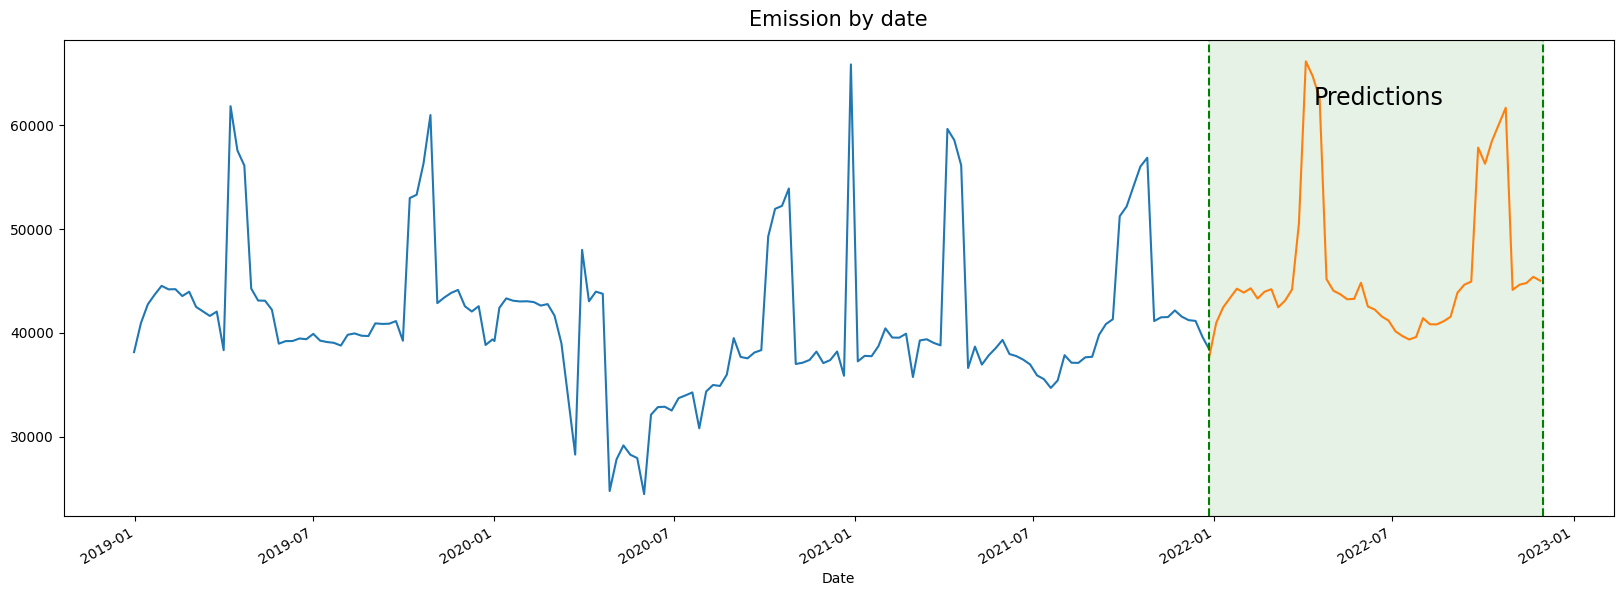

In [44]:
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
pred_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-12-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2021-12-27'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp ('2022-04-12'), 62000, "Predictions", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()

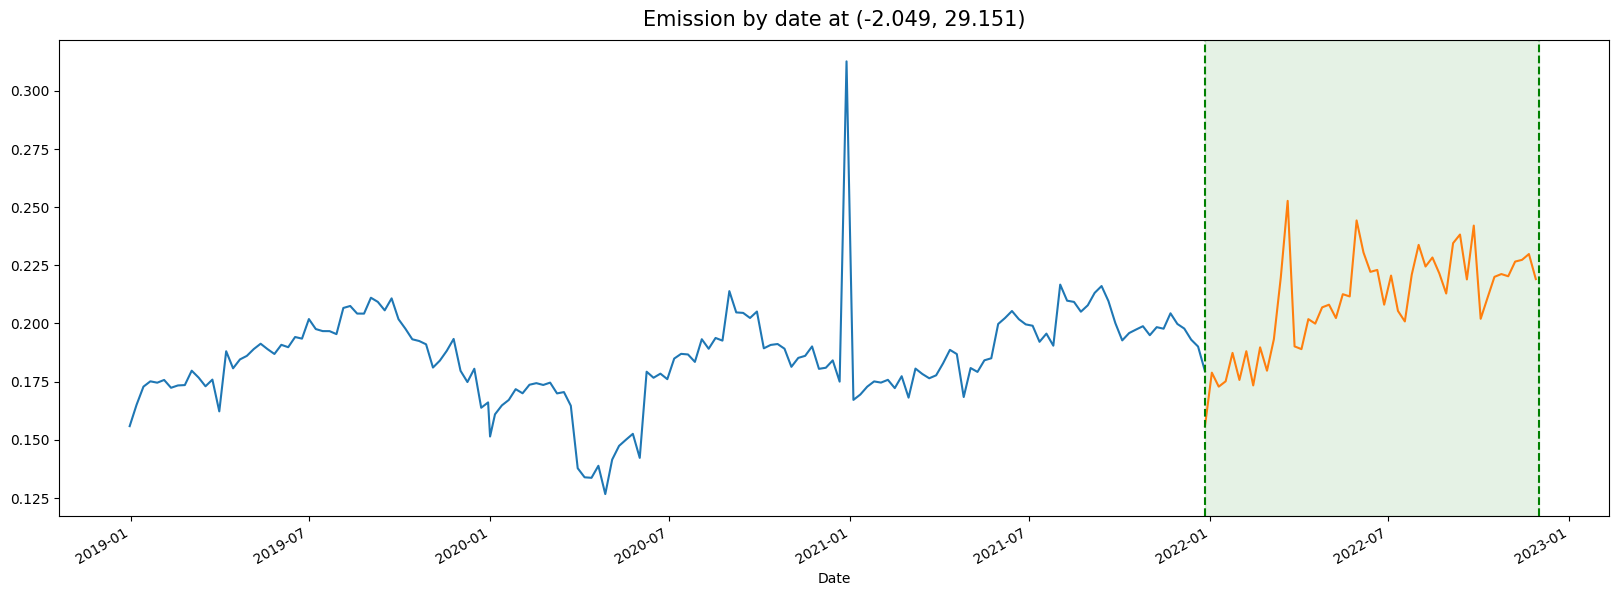

In [45]:
# Emission by date in a random location
rand_latitude, rand_longitude = test.sample()[['latitude', 'longitude']].values.reshape((-1, ))

train_plot[(train_plot['latitude'] == rand_latitude) & (train_plot['longitude'] == rand_longitude)].groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
pred_plot[(pred_plot['latitude'] == rand_latitude) & (pred_plot['longitude'] == rand_longitude)].groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-12-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2021-12-27'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-01'), linestyle = "--", color='green')

plt.title(f'Emission by date at ({rand_latitude}, {rand_longitude})', size=15, pad=10)
plt.show()

## Save submission

In [46]:
sample_submission.to_csv('/Users/jacobc/Desktop/InputRwanda/SavedOutput/solution.csv')